In [1]:
import polars as pl
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [6]:

train_log = pl.read_parquet("../data/train_log.parquet")
test_log = pl.read_parquet("../data/test_log.parquet")
train_label = pl.read_parquet("../data/train_label_cv.parquet")
yado_df = pl.read_parquet("../data/yado.parquet")

In [60]:
# for area_group in ["wid_cd", "ken_cd", "lrg_cd", "sml_cd"]:
log = pl.concat([train_log, test_log])
area_group = "sml_cd"

log_count = log.group_by("session_id").count().filter(pl.col("count") > 1)
coappear = (log
           .join(yado_df[["yad_no", area_group]], on="yad_no")
           .filter(pl.col("session_id")
                   .is_in(log_count["session_id"]))
           .pivot(index="session_id", columns="seq_no", values=area_group)
            .to_numpy()
          )
           


In [61]:
train_data = [[a for a in sess if a is not None] for sess in coappear[:, 1:]]
train_data = [[a for a in set(sess)] for sess in train_data if len(set(sess)) > 1]

In [62]:
area2vec_datapath = f"../data/item2vec/area2vec_train_{area_group}.txt"
with open(area2vec_datapath, 'w') as file:
    for line in train_data:
        file.write(" ".join(map(str, line)) + "\n")

In [68]:
from gensim.models import word2vec

sentences = word2vec.LineSentence(area2vec_datapath)
model = word2vec.Word2Vec(sentences, vector_size=5, window=10, epochs=1000, 
                          # sample=0.000001,
                          seed=42, 
                          # ns_exponent=0.2, 
                          # negative=10,
                          # min_count=2,
                          shrink_windows=False
                         )

In [64]:
comp_area = "wid_cd"
area_names = yado_df.unique(area_group)[[comp_area, area_group]]
wid_unique = yado_df.unique(comp_area)[comp_area]

embbed = {area: model.wv[area] for area in area_names[area_group].to_list() if area in model.wv}

embbed_comp_area = [area_names.filter(pl.col(area_group) == area)[comp_area][0] for area in list(embbed.keys())]



In [65]:
emb_stack = np.stack(list(embbed.values()), axis=0)

data_dict = {
    "area": list(embbed.keys()),
}
for i  in range(5):
    data_dict[f"area_emb_{i+1}"] = emb_stack[:, i]


emb_pl = pl.DataFrame(data_dict)



In [66]:
emb_pl.write_parquet(f"../data/item2vec/area_emb_{area_group}.parquet")

In [57]:
np.array(list(embbed.values())).shape

(219, 5)

In [58]:
emb_pl

area,area_emb_1,area_emb_2,area_emb_3,area_emb_4,area_emb_5
str,f32,f32,f32,f32,f32
"""9d6a46da05976c…",1.445439,-0.384149,-0.93367,0.850096,-0.26356
"""90625510535055…",3.108993,-0.213832,-0.036217,3.775176,5.968372
"""41e20110b38f12…",4.43266,-2.383548,-5.059701,-1.110572,-0.287054
"""0154defaec6c10…",0.258651,1.29151,-0.870242,-0.286928,0.627911
"""e6437021039c8c…",0.64071,-1.58972,-2.553225,-0.758163,2.25101
"""63083678169ddd…",1.419872,0.713679,-0.535751,-0.014771,6.483956
"""333bcf3094c1ca…",2.823969,8.177665,-3.537114,1.400312,3.00845
"""320d6f145b0de1…",0.759067,2.139092,-3.368767,4.400422,5.524367
"""19caa95d568040…",3.054228,-3.244353,-5.441466,-2.365735,2.757388


In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 0, perplexity=)
X_embedded = tsne.fit_transform(np.array(list(embbed.values())))

In [14]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({
    "x": X_embedded[:, 0],
    "y": X_embedded[:, 1],
    "comp_area": embbed_comp_area
})

<Axes: xlabel='x', ylabel='y'>

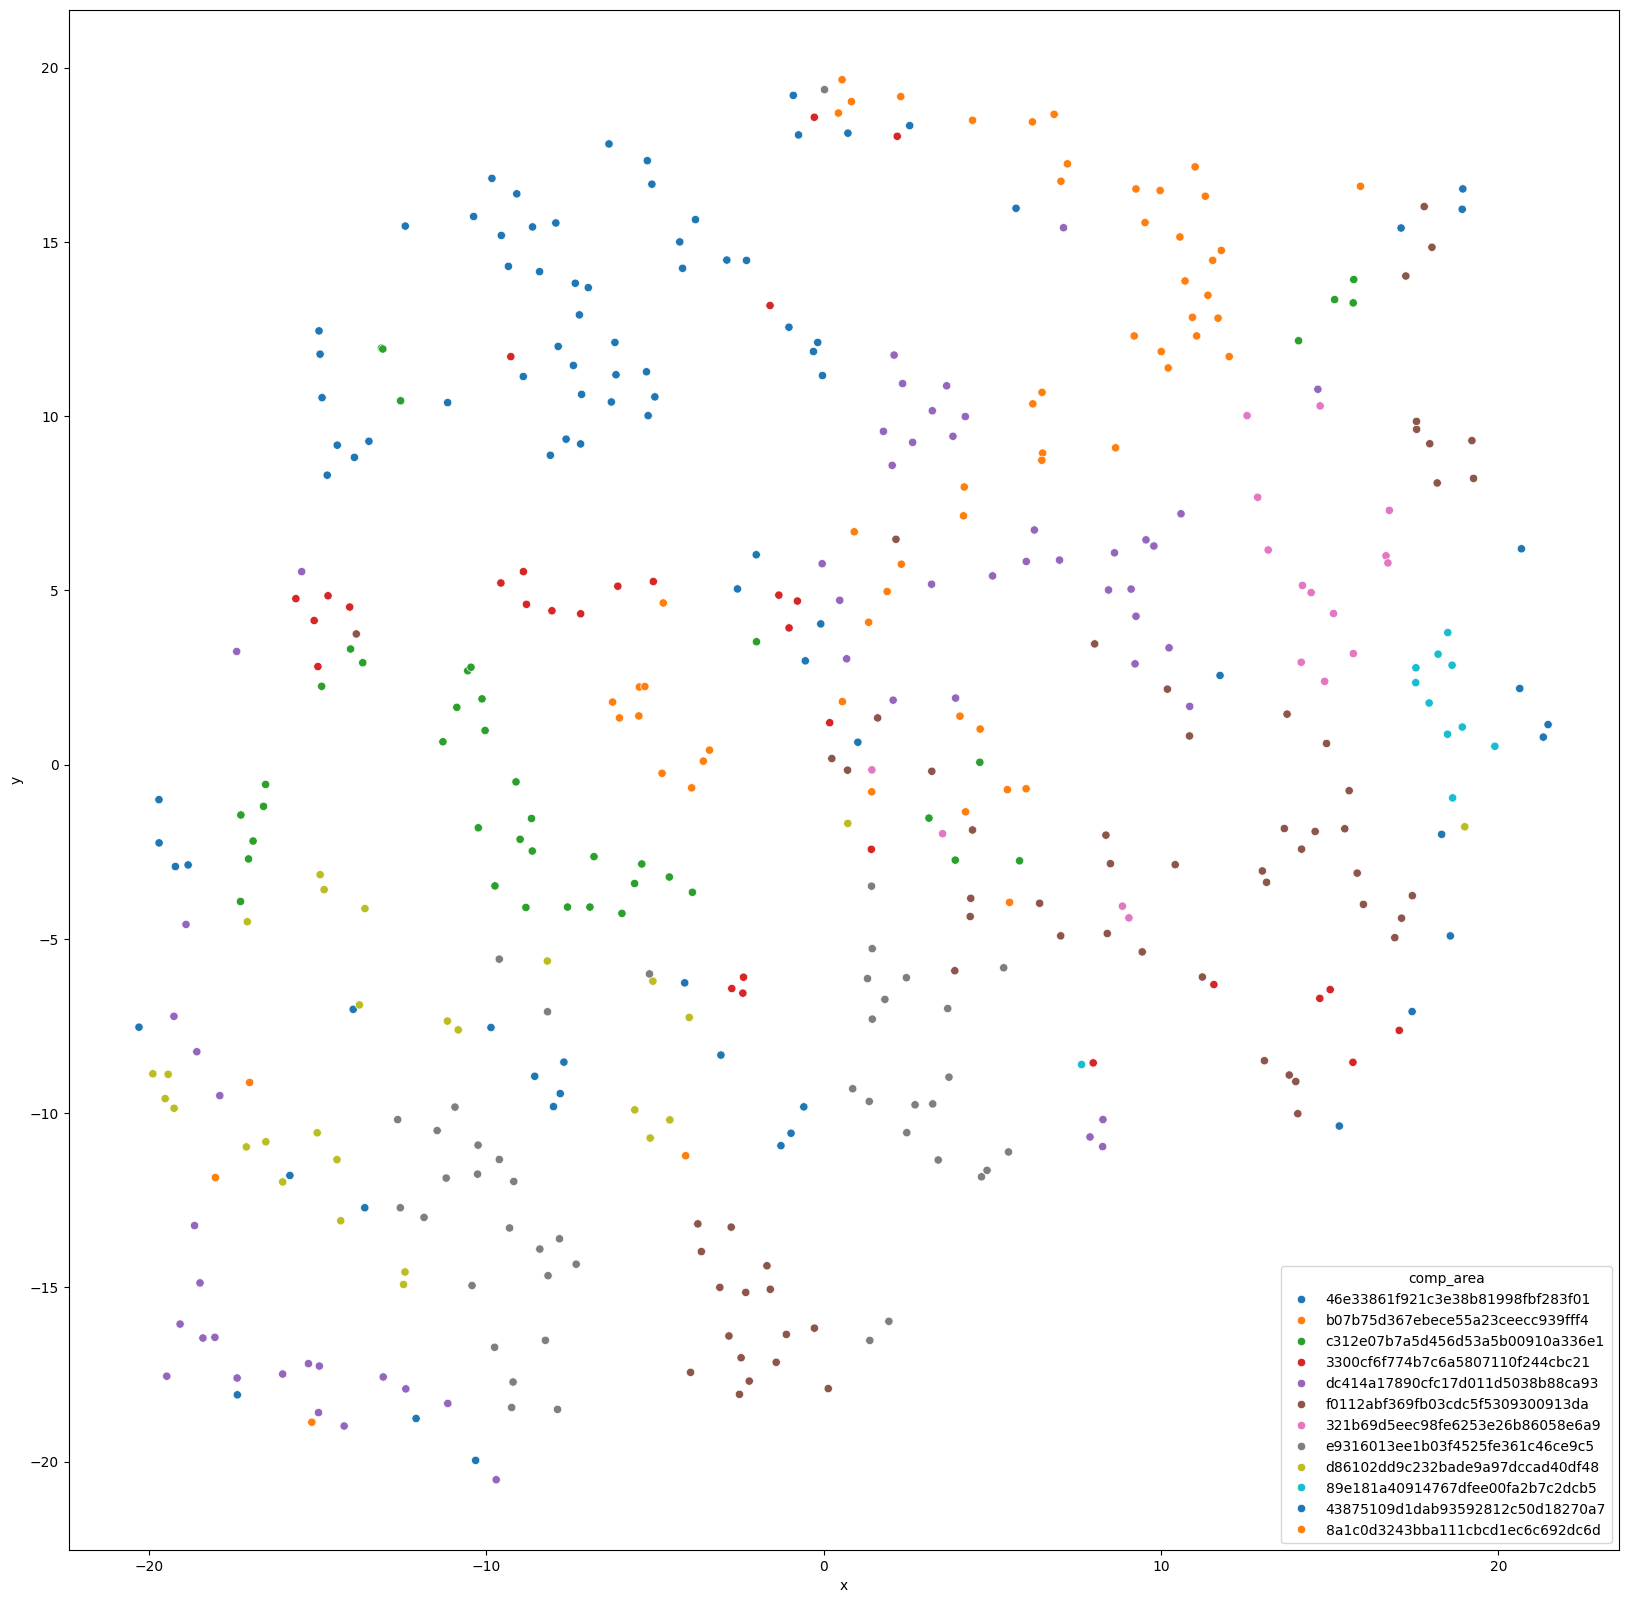

In [15]:
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.scatterplot(x='x', y='y', hue="comp_area", data=df, palette="tab10")


In [117]:
train_log = pl.read_parquet("../data/train_log.parquet")
train_label = pl.read_parquet("../data/train_label_cv.parquet")
yado_df = pl.read_parquet("../data/yado.parquet")
test_log = pl.read_parquet("../data/test_log.parquet")

In [118]:
log = pl.concat([train_log, test_log])

In [107]:
for 

SyntaxError: invalid syntax (1235331270.py, line 1)

In [ ]:
yado_df[["wid_cd", "ken_cd", "lrg_cd", "sml_cd"]].unique(["wid_cd", "ken_cd", "lrg_cd", "sml_cd"])

In [46]:
import torch
from torch import nn

(12,)

session_id,yad_no,fold
str,i64,i64
"""000007603d533d…",4101,0
"""0000ca043ed437…",8253,2
"""0000d4835cf113…",4863,4
"""0000fcda1ae1b2…",1652,2
"""000104bdffaaad…",96,1
"""00011afe25c343…",4823,4
"""000125c737df18…",10378,0
"""0001763050a10b…",10362,3
"""000178c4d4d567…",1227,3
